In [2]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
import glob
import seaborn as sns
sns.set()
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison

## Import of the previously extracted transactions

In [3]:
data = pd.read_csv('bloxberg.csv')

In [4]:
data

,Unnamed: 0,timestamp,blocknumber,to,from,gas,gasPrice,nonce,value
0,0,1547107485,33,NaN,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,889637,0,0,0
1,1,1547107625,61,NaN,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,1952182,0,1,0
2,2,1547107680,72,0x9850711951A84Ef8a2A31a7868d0dCa34B0661cA,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,45333,0,2,0
3,3,1547111675,845,0x9849379b89aB24c18C8871d56d1Ad41E00d9eAae,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,1000000,50000000000,3,0
4,4,1547111745,859,0x9849379b89aB24c18C8871d56d1Ad41E00d9eAae,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,1000000,50000000000,4,0
...,...,...,...,...,...,...,...,...,...
9527281,9527281,1597489805,7535649,0xD216153c06E857cD7f72665E0aF1d7D82172F494,0x4eD1cA7563Ae29FE02d278a3fEE4876C9BA317d3,52216,1000000,13721,0
9527282,9527282,1597490350,7535715,0xFe19CA9dCaba073cECeE7dC2b36b7d45dbeEdFf0,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,53651,200000000000000000
9527283,9527283,1597490365,7535717,0xD216153c06E857cD7f72665E0aF1d7D82172F494,0x4eD1cA7563Ae29FE02d278a3fEE4876C9BA317d3,52276,1000000,13722,0
9527284,9527284,1597490410,7535721,0xD216153c06E857cD7f72665E0aF1d7D82172F494,0x4eD1cA7563Ae29FE02d278a3fEE4876C9BA317d3,52216,1000000,13723,0


## Filtering and Cleanup

Filter the data and exclude noise, such that only faucet transactions are left.
Faucet transactions are defined by those transactions from the faucet adress to an adress that is not acting as custodial wallet for a bloxberg service.


In [8]:
faucet_adress = '0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088'
certify_research_data_sc_adress = '0xE5a9654C7e190701016EBf18206020bf16D8Beab'

gas_used_ether_tx = 30000 # plain ether transaction will have this gas usage

all_faucet_tx = data[(data['from'] == faucet_adress) & (data['gas'] == gas_used_ether_tx)]
all_faucet_tx

,Unnamed: 0,timestamp,blocknumber,to,from,gas,gasPrice,nonce,value
15,15,1547112880,1071,0xD748BF41264b906093460923169643f45BDbC32e,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,15,500000000000000000
75,75,1547553475,89190,0xf9f4EF25373E0dabdd80eed7299Fd5234F7D4d89,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,69,500000000000000000
76,76,1547553500,89195,0xf9f4EF25373E0dabdd80eed7299Fd5234F7D4d89,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,70,500000000000000000
187,187,1548080680,194631,0xb0Eef975F568A6CDce67E156113629CB2791cf3b,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,167,500000000000000000
188,188,1548080710,194637,0xb0Eef975F568A6CDce67E156113629CB2791cf3b,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,168,500000000000000000
...,...,...,...,...,...,...,...,...,...
9525510,9525510,1597382845,7522755,0xFe19CA9dCaba073cECeE7dC2b36b7d45dbeEdFf0,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,53530,200000000000000000
9525639,9525639,1597400805,7524898,0xFe19CA9dCaba073cECeE7dC2b36b7d45dbeEdFf0,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,53551,200000000000000000
9525717,9525717,1597412135,7526248,0xFe19CA9dCaba073cECeE7dC2b36b7d45dbeEdFf0,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,53563,200000000000000000
9527196,9527196,1597470890,7533360,0xFe19CA9dCaba073cECeE7dC2b36b7d45dbeEdFf0,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,53629,200000000000000000


## General Overview

In [62]:
tx_per_address = all_faucet_tx['to'].value_counts()
display("Total number of addresses receiving tx from faucet: {}".format(tx_per_address.size))

'Total number of addresses receiving tx from faucet: 235'

In [68]:
many_tx = 8
adresses_with_many_tx = tx_per_address[tx_per_address > many_tx]
a_with_many_tx_perc = adresses_with_many_tx.size / tx_per_address.size

display("Percentage of accounts with many transctions (with many being considered more than {}): {}".format(many_tx, a_with_many_tx_perc))


'Percentage of accounts with many transctions (with many being considered more than 8): 0.2127659574468085'

Text(0.5, 1.0, 'Distribution of faucet transaction count for single adress for count > 8')

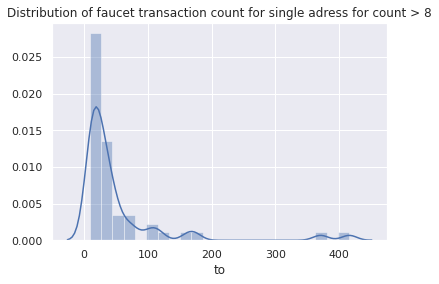

In [76]:
sns.distplot(adresses_with_many_tx).set_title('Distribution of faucet transaction count for single adress for count > {}'.format(many_tx))

In [71]:
adresses_with_many_tx

0x2CedAee1c717535BBDDacAB27A56FF81ffDA2a78    416
0x7b0bfA9F3fd91cB111a82c691971E1BABe8b72d6    371
0xA94A6A58dd1fc6a8a3E8E75D123f8e7F30026c00    174
0x01b7492A43416eD673a75A1BF5602312e25C7D24    163
0x197E62a8dDaF6015bd26Cbd52465FCCc4FC6Cf44    118
0x3E3cBd02E9e0442C5E234678A352F43e1209FB7E    109
0xFe19CA9dCaba073cECeE7dC2b36b7d45dbeEdFf0    100
0xB364dB24A41D807Ad12A37506bD79CF2A397E643     78
0x15433DA387451F9dE4565280C85506CB71aF9376     72
0xf17f52151EbEF6C7334FAD080c5704D77216b732     66
0x737756B173D2F41D63a46Ed6094DAF7E8a78F997     54
0x3253Bf11fb207543f6aF73bBC8625775d22aB8DE     49
0x68bc4ea819f98201E897EC8306897FD3FF64A5a3     48
0x094191169aac3413BD1d91B6a84309021b217439     43
0xaEc7be3Ca0fF850CB03A39D7A8f3ee62e4F15E65     43
0x7FEb55AD745CcbDfc028b2bBDB211a6256163dE4     43
0xA73Af2d1bd6809cD8002a6DB230C32e31992FA8C     41
0x5e923C02Eeb0730eb4CB5EDb6708651B5a47529D     35
0x8730584dCDd4550F335e1ccfb32Fa80252B9b02C     33
0x2A0b58ae4347D87B1C7CD6FEB2e3A654B69655DD     33


In [67]:
faucet_tx_counts = faucet_tx['to'].value_counts().to_frame()

In [69]:
pd.set_option('display.max_rows', 100)
faucet_tx_counts[faucet_tx_counts['to'] > 7]

,to
0xE5a9654C7e190701016EBf18206020bf16D8Beab,50293
0x2CedAee1c717535BBDDacAB27A56FF81ffDA2a78,416
0x7b0bfA9F3fd91cB111a82c691971E1BABe8b72d6,371
0xE8958c0556a005cc10B3DAC4144b2358B28E2Aaa,207
0xA94A6A58dd1fc6a8a3E8E75D123f8e7F30026c00,174
0x01b7492A43416eD673a75A1BF5602312e25C7D24,163
0x197E62a8dDaF6015bd26Cbd52465FCCc4FC6Cf44,118
0x3E3cBd02E9e0442C5E234678A352F43e1209FB7E,109
0xFe19CA9dCaba073cECeE7dC2b36b7d45dbeEdFf0,100
0xB364dB24A41D807Ad12A37506bD79CF2A397E643,78


In [103]:
x_1 =data[(data['to'] == '0x3A4D08d39Bc461EE7f8F88147469dA51C9b6472f') & (data['from'] == '0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088')]


In [90]:
(max(x_1['timestamp'])-min(x_1['timestamp'])) / len(x_1) / 1000

34.372

In [102]:
#suspicious account

y_1 =data[(data['to'] == '0x3E3cBd02E9e0442C5E234678A352F43e1209FB7E') & (data['from'] == '0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088')]


In [92]:
(max(y_1['timestamp'])-min(y_1['timestamp'])) / len(x_1) / 1000

0.793

In [101]:
z_1 =data[(data['to'] == '0xE8958c0556a005cc10B3DAC4144b2358B28E2Aaa') & (data['from'] == '0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088')]


In [97]:
(max(z_1['timestamp'])-min(z_1['timestamp'])) / len(z_1) / 1000

10.415555555555555

In [100]:
#suspicious

a_1 =data[(data['to'] == '0x2CedAee1c717535BBDDacAB27A56FF81ffDA2a78') & (data['from'] == '0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088')]


In [96]:
(max(a_1['timestamp'])-min(a_1['timestamp'])) / len(a_1) / 1000

4.752728365384615

In [99]:
b =data[(data['to'] == '0xE5a9654C7e190701016EBf18206020bf16D8Beab') & (data['from'] == '0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088')]


In [106]:
c =data[(data['to'] == '0x7b0bfA9F3fd91cB111a82c691971E1BABe8b72d6') & (data['from'] == '0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088')]


In [105]:
(max(c['timestamp'])-min(c['timestamp'])) / len(c) / 1000

17.452075471698112

In [107]:
d =data[(data['to'] == '0xA94A6A58dd1fc6a8a3E8E75D123f8e7F30026c00') & (data['from'] == '0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088')]

d

,Unnamed: 0,timestamp,blocknumber,to,from,gas,gasPrice,nonce
4458054,4458054,1569524270,3398313,0xA94A6A58dd1fc6a8a3E8E75D123f8e7F30026c00,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,1472
4458055,4458055,1569524310,3398317,0xA94A6A58dd1fc6a8a3E8E75D123f8e7F30026c00,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,1473
4458076,4458076,1569524340,3398322,0xA94A6A58dd1fc6a8a3E8E75D123f8e7F30026c00,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,1474
4458077,4458077,1569524385,3398327,0xA94A6A58dd1fc6a8a3E8E75D123f8e7F30026c00,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,1475
4458099,4458099,1569524415,3398332,0xA94A6A58dd1fc6a8a3E8E75D123f8e7F30026c00,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,1476
...,...,...,...,...,...,...,...,...
6485253,6485253,1575659600,4255165,0xA94A6A58dd1fc6a8a3E8E75D123f8e7F30026c00,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,26962
6485281,6485281,1575659645,4255173,0xA94A6A58dd1fc6a8a3E8E75D123f8e7F30026c00,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,26963
6705722,6705722,1576179545,4321378,0xA94A6A58dd1fc6a8a3E8E75D123f8e7F30026c00,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,27610
6705737,6705737,1576179565,4321381,0xA94A6A58dd1fc6a8a3E8E75D123f8e7F30026c00,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,27611


In [108]:
(max(d['timestamp'])-min(d['timestamp'])) / len(d) / 1000

38.248936781609196

In [109]:
e =data[(data['to'] == '0x197E62a8dDaF6015bd26Cbd52465FCCc4FC6Cf44') & (data['from'] == '0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088')]

e

,Unnamed: 0,timestamp,blocknumber,to,from,gas,gasPrice,nonce
6859604,6859604,1576513845,4363866,0x197E62a8dDaF6015bd26Cbd52465FCCc4FC6Cf44,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,28182
6859619,6859619,1576513860,4363868,0x197E62a8dDaF6015bd26Cbd52465FCCc4FC6Cf44,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,28183
6859634,6859634,1576513880,4363871,0x197E62a8dDaF6015bd26Cbd52465FCCc4FC6Cf44,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,28184
6859648,6859648,1576513895,4363874,0x197E62a8dDaF6015bd26Cbd52465FCCc4FC6Cf44,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,28185
6859649,6859649,1576513915,4363877,0x197E62a8dDaF6015bd26Cbd52465FCCc4FC6Cf44,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,28186
...,...,...,...,...,...,...,...,...
6877450,6877450,1576543545,4368023,0x197E62a8dDaF6015bd26Cbd52465FCCc4FC6Cf44,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,28328
6877466,6877466,1576543565,4368026,0x197E62a8dDaF6015bd26Cbd52465FCCc4FC6Cf44,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,28329
6877916,6877916,1576544300,4368130,0x197E62a8dDaF6015bd26Cbd52465FCCc4FC6Cf44,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,28331
6877917,6877917,1576544315,4368132,0x197E62a8dDaF6015bd26Cbd52465FCCc4FC6Cf44,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,28332


In [110]:
(max(e['timestamp'])-min(e['timestamp'])) / len(e) / 1000

0.2584745762711864

In [117]:
pd.set_option('display.max_rows', 100)
new_data =faucet_tx_counts[faucet_tx_counts['to'] > 7]

In [114]:
f =data[(data['to'] == '0x01b7492A43416eD673a75A1BF5602312e25C7D24') & (data['from'] == '0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088')]




In [113]:
(max(f['timestamp'])-min(f['timestamp'])) / len(f) / 1000

11.393282208588957

In [115]:
g =data[(data['to'] == '0x3E3cBd02E9e0442C5E234678A352F43e1209FB7E') & (data['from'] == '0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088')]

g



,Unnamed: 0,timestamp,blocknumber,to,from,gas,gasPrice,nonce
4442389,4442389,1569473820,3391956,0x3E3cBd02E9e0442C5E234678A352F43e1209FB7E,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,1363
4442398,4442398,1569473835,3391957,0x3E3cBd02E9e0442C5E234678A352F43e1209FB7E,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,1364
4442402,4442402,1569473850,3391959,0x3E3cBd02E9e0442C5E234678A352F43e1209FB7E,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,1365
4442413,4442413,1569473870,3391963,0x3E3cBd02E9e0442C5E234678A352F43e1209FB7E,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,1366
4442418,4442418,1569473910,3391967,0x3E3cBd02E9e0442C5E234678A352F43e1209FB7E,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,1367
...,...,...,...,...,...,...,...,...
4446069,4446069,1569485570,3393444,0x3E3cBd02E9e0442C5E234678A352F43e1209FB7E,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,1467
4446070,4446070,1569485595,3393447,0x3E3cBd02E9e0442C5E234678A352F43e1209FB7E,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,1468
4446091,4446091,1569485655,3393456,0x3E3cBd02E9e0442C5E234678A352F43e1209FB7E,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,1469
4446092,4446092,1569485685,3393458,0x3E3cBd02E9e0442C5E234678A352F43e1209FB7E,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,1470


In [116]:
(max(g['timestamp'])-min(g['timestamp'])) / len(g) / 1000

0.10912844036697249

In [118]:
new_data

,to
0xE5a9654C7e190701016EBf18206020bf16D8Beab,50293
0x2CedAee1c717535BBDDacAB27A56FF81ffDA2a78,416
0x7b0bfA9F3fd91cB111a82c691971E1BABe8b72d6,371
0xE8958c0556a005cc10B3DAC4144b2358B28E2Aaa,207
0xA94A6A58dd1fc6a8a3E8E75D123f8e7F30026c00,174
0x01b7492A43416eD673a75A1BF5602312e25C7D24,163
0x197E62a8dDaF6015bd26Cbd52465FCCc4FC6Cf44,118
0x3E3cBd02E9e0442C5E234678A352F43e1209FB7E,109
0xFe19CA9dCaba073cECeE7dC2b36b7d45dbeEdFf0,100
0xB364dB24A41D807Ad12A37506bD79CF2A397E643,78


In [123]:
new_data.index[8]

'0xFe19CA9dCaba073cECeE7dC2b36b7d45dbeEdFf0'

In [124]:
h =data[(data['to'] == '0xFe19CA9dCaba073cECeE7dC2b36b7d45dbeEdFf0') & (data['from'] == '0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088')]

h


,Unnamed: 0,timestamp,blocknumber,to,from,gas,gasPrice,nonce
9494553,9494553,1591682370,6757607,0xFe19CA9dCaba073cECeE7dC2b36b7d45dbeEdFf0,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,46637
9494607,9494607,1591705840,6760668,0xFe19CA9dCaba073cECeE7dC2b36b7d45dbeEdFf0,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,46664
9494650,9494650,1591731320,6764039,0xFe19CA9dCaba073cECeE7dC2b36b7d45dbeEdFf0,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,46696
9494699,9494699,1591768095,6769031,0xFe19CA9dCaba073cECeE7dC2b36b7d45dbeEdFf0,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,46738
9494822,9494822,1591847940,6779865,0xFe19CA9dCaba073cECeE7dC2b36b7d45dbeEdFf0,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,46827
9494840,9494840,1591862315,6781817,0xFe19CA9dCaba073cECeE7dC2b36b7d45dbeEdFf0,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,46844
9494931,9494931,1591900350,6786978,0xFe19CA9dCaba073cECeE7dC2b36b7d45dbeEdFf0,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,46888
9494996,9494996,1591954595,6794682,0xFe19CA9dCaba073cECeE7dC2b36b7d45dbeEdFf0,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,46950
9495027,9495027,1591972825,6797285,0xFe19CA9dCaba073cECeE7dC2b36b7d45dbeEdFf0,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,46971
9495095,9495095,1592024385,6804627,0xFe19CA9dCaba073cECeE7dC2b36b7d45dbeEdFf0,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,47030


In [128]:
(max(h['timestamp'])-min(h['timestamp'])) / len(h) / 100 / 60

9.679966666666667

In [126]:
new_data.index[9]

'0xB364dB24A41D807Ad12A37506bD79CF2A397E643'

In [129]:
ab =data[(data['to'] == '0xB364dB24A41D807Ad12A37506bD79CF2A397E643') & (data['from'] == '0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088')]

ab


,Unnamed: 0,timestamp,blocknumber,to,from,gas,gasPrice,nonce
6705765,6705765,1576179630,4321389,0xB364dB24A41D807Ad12A37506bD79CF2A397E643,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,27613
6705810,6705810,1576179725,4321401,0xB364dB24A41D807Ad12A37506bD79CF2A397E643,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,27615
6705823,6705823,1576179740,4321403,0xB364dB24A41D807Ad12A37506bD79CF2A397E643,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,27616
6705826,6705826,1576179755,4321405,0xB364dB24A41D807Ad12A37506bD79CF2A397E643,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,27617
6705839,6705839,1576179770,4321408,0xB364dB24A41D807Ad12A37506bD79CF2A397E643,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,27618
6705840,6705840,1576179790,4321411,0xB364dB24A41D807Ad12A37506bD79CF2A397E643,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,27619
6705855,6705855,1576179820,4321413,0xB364dB24A41D807Ad12A37506bD79CF2A397E643,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,27620
6705858,6705858,1576179830,4321414,0xB364dB24A41D807Ad12A37506bD79CF2A397E643,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,27621
6705900,6705900,1576179925,4321426,0xB364dB24A41D807Ad12A37506bD79CF2A397E643,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,27622
6705915,6705915,1576179945,4321429,0xB364dB24A41D807Ad12A37506bD79CF2A397E643,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,27623


In [136]:
new_data.index[10]

'0x15433DA387451F9dE4565280C85506CB71aF9376'

In [137]:
ac =data[(data['to'] == '0x15433DA387451F9dE4565280C85506CB71aF9376') & (data['from'] == '0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088')]

ac


,Unnamed: 0,timestamp,blocknumber,to,from,gas,gasPrice,nonce
3339479,3339479,1565554495,2929199,0x15433DA387451F9dE4565280C85506CB71aF9376,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,1277
3339586,3339586,1565554950,2929248,0x15433DA387451F9dE4565280C85506CB71aF9376,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,1278
9479835,9479835,1585075245,5673481,0x15433DA387451F9dE4565280C85506CB71aF9376,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,38869
9479836,9479836,1585075260,5673484,0x15433DA387451F9dE4565280C85506CB71aF9376,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,38870
9481879,9481879,1585854255,5818267,0x15433DA387451F9dE4565280C85506CB71aF9376,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,39749
9481880,9481880,1585854270,5818270,0x15433DA387451F9dE4565280C85506CB71aF9376,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,39750
9489822,9489822,1589924185,6494313,0x15433DA387451F9dE4565280C85506CB71aF9376,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,44570
9490265,9490265,1590162950,6532390,0x15433DA387451F9dE4565280C85506CB71aF9376,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,44849
9491153,9491153,1590525395,6590496,0x15433DA387451F9dE4565280C85506CB71aF9376,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,45267
9491550,9491550,1590690375,6616014,0x15433DA387451F9dE4565280C85506CB71aF9376,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,45461


In [159]:
new_data.index[21]

'0x8730584dCDd4550F335e1ccfb32Fa80252B9b02C'

In [160]:
ad =data[(data['to'] == '0x8730584dCDd4550F335e1ccfb32Fa80252B9b02C') & (data['from'] == '0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088')]

ad


,Unnamed: 0,timestamp,blocknumber,to,from,gas,gasPrice,nonce
9476691,9476691,1584384130,5541452,0x8730584dCDd4550F335e1ccfb32Fa80252B9b02C,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,38083
9485437,9485437,1587197115,6051191,0x8730584dCDd4550F335e1ccfb32Fa80252B9b02C,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,41401
9485483,9485483,1587236525,6058125,0x8730584dCDd4550F335e1ccfb32Fa80252B9b02C,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,41446
9485544,9485544,1587290230,6067475,0x8730584dCDd4550F335e1ccfb32Fa80252B9b02C,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,41506
9485555,9485555,1587298085,6068845,0x8730584dCDd4550F335e1ccfb32Fa80252B9b02C,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,41516
9485646,9485646,1587374655,6082031,0x8730584dCDd4550F335e1ccfb32Fa80252B9b02C,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,41604
9485669,9485669,1587390035,6084610,0x8730584dCDd4550F335e1ccfb32Fa80252B9b02C,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,41627
9485690,9485690,1587407365,6087635,0x8730584dCDd4550F335e1ccfb32Fa80252B9b02C,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,41647
9485759,9485759,1587463110,6097157,0x8730584dCDd4550F335e1ccfb32Fa80252B9b02C,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,41710
9485826,9485826,1587498425,6103083,0x8730584dCDd4550F335e1ccfb32Fa80252B9b02C,0xaB59A1ea1aC9af9F77518b9B4AD80942adE35088,30000,1000000000,41751
